# Предсказание моих шахматных результатов. Ход конём

Приветствую всех! Что собственно говоря, происходит?

Меня зовут Максим, и я шахматист. Я играю в шахматы с 3 лет, и это был мой осознанный выбор (нет). Я имею звание КМС и очень люблю играть в шахматы онлайн. Я сейчас играю на одном из лучших сайтов для игры онлайн - lichess.com. На апрель 2021 года у меня было сыграно около 2000 партий, в основном это блиц (blitz, контроль времени 3-5 минут на партию) или пуля (bullet, контроль времени 1-2 минуты на партию). Мне стало интересно, возможно ли предсказать с достаточной точностью, выиграю ли я определенную партию или нет, исходя из данных, которые можно собрать с сайта lichess? Я скачал базу моих партий на этом сайте и начал разбираться...

## 1. Постановка задачи. Обзор имеющихся данных

Загружаем нужные библиотеки для начала

In [2]:
%matplotlib inline
import re
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from chess_lib import create_df_from_pgn, statistics_eco, create_X, create_my_result, plot_auc_roc
from sklearn.linear_model import LogisticRegression
from itertools import combinations

Здесь библиотека chess_lib - это файл, который я создал сам. В нём все функции для парсинга pgn файлов и создания из них Dataframe-ов, создания фичей и формирования из них train и test Dataframe-ов, создания Series для целевой переменной и прочее. Но об этом позже...

База данных партий хранится в файле формата .pgn (это такой стандарт для шахматных баз данных). Это по сути текстовый файл, отформатированный определенным образом. Давайте взглянем на его кусочек.

In [3]:
with open('C:\python\ML_coursera\Data Science\lichess_base\lichess_shahmatpatblog_2021-04-20.pgn', 'r', encoding='utf-8') as f:
    text_file = f.read()
print(text_file[:1000])

[Event "Rated Bullet game"]
[Site "https://lichess.org/XvR2rQFZ"]
[Date "2021.04.20"]
[White "AlexanderChetverik"]
[Black "shahmatpatblog"]
[Result "1-0"]
[UTCDate "2021.04.20"]
[UTCTime "08:27:29"]
[WhiteElo "2058"]
[BlackElo "2194"]
[WhiteRatingDiff "+8"]
[BlackRatingDiff "-7"]
[Variant "Standard"]
[TimeControl "120+1"]
[ECO "A45"]
[Termination "Normal"]

1. d4 Nf6 2. f4 d5 3. Nf3 c5 4. e3 Nc6 5. b3 g6 6. dxc5 Bg7 7. Bb2 Qa5+ 8. Nbd2 Qxc5 9. Nd4 Bg4 10. Be2 Bxe2 11. Qxe2 O-O 12. O-O Nxd4 13. Bxd4 Qxc2 14. Rfc1 Qf5 15. Rc7 b6 16. Rxe7 Rfe8 17. Rxe8+ Rxe8 18. Qb5 Qd7 19. Qxd7 Nxd7 20. Bxg7 Kxg7 21. Kf2 Nc5 22. Rd1 a5 23. g4 f6 24. Kf3 Kf7 25. Nb1 Ke6 26. Nc3 Rd8 27. h4 h6 28. Nb5 Rd7 29. Nd4+ Kf7 30. f5 g5 31. h5 Ne4 32. Nb5 Ke7 33. Rd3 Nc5 34. Rd4 Rd8 35. Nc3 Rd6 36. Nxd5+ Kf7 37. Nc3 Rxd4 38. exd4 Nb7 39. Ke4 Ke7 40. Nb5 Kd7 41. d5 Nc5+ 42. Kd4 Nb7 43. Nc3 Nd6 44. Ne4 Nb5+ 45. Kc4 Na3+ 46. Kd3 b5 47. Nxf6+ Kd6 48. Ne4+ Kxd5 49. Nf6+ Ke5 50. Ng8 Kf4 51. Nxh6 b4 52. f6 Nb5 53. f7 1-0



Здесь отображена информация о последних (по хронометражу) двух играх. Вначале идёт заголовок партии, затем ходы партии. Как мы видим, мы можем воспользоваться следующей информацией:

Event - тип события. Может быть обычная блиц партия, обычная пуля-партия, какой-нибудь турнир (если сыграна в турнире)

Site - ссылка на страничку партии

Date - дата партии

White - никнейм игрока, играющего белыми

Black - никнейм игрока, играющего черными

Result - результат партии (1-0, 0-1, 1/2-1/2)

UTCDate - дата UTC

UTCTime - время UTC (-4 часа от моего часового пояса)

WhiteElo - рейтинг (Elo) белых

BlackElo - рейтинг (Elo) черных

WhiteRatingDiff - изменение рейтинга белых по результату данной партии

BlackRatingDiff - изменение рейтинга черных по результату данной партии

Variant - тип выбранного режима игры (обычные, шахматы Фишера, поддавки и т.п.). Я играю только обычные (Standard)

TimeControl - контроль времени. "180+2" например, значит, что контроль времени 3 минуты (180 с) с добавлением 2 с на ход.

ECO - дебютный индекс партии. Определяет, какой дебют был разыгран в партии

Termination - тип окончания партии. Нормальное значит кто-то сдался, или мат, или согласились на ничью. Может быть еще просрочка времени

Набор ходов партии в виде стандартной шахматной нотации

In [4]:
path_to_file = 'C:\python\ML_coursera\Data Science\lichess_base\lichess_shahmatpatblog_2021-04-20.pgn'
feature_names = ['Event', 'White', 'Black', 'Result', 'UTCDate', 'UTCTime', 'WhiteElo', 'BlackElo', 'TimeControl', 'ECO']

Я скачал базу данных своих партий на 20.04.2021 в формате .pgn, которая содержит в текстовом виде информацию о сыгранных мной партиях на сайте lichess.com. Она содержит 1037 партий за период 05.2020 - 04.2021. Часть этих партий будет использоваться для обучения, другая часть - для проверки модели. Выше я прописал путь к файлу и задал список параметров, которые я хочу выдернуть из базы данных. Мне нужны далеко не все из имеющихся данных.

Моя задача - предсказать результат партий из тестового набора игр (разобью базу данных при помощи train_test_split позже). Предсказание заключается в определении, выиграю ли я эту партию или нет. Это задача бинарной классификации. Для упрощения задачи, ничейные результаты принимаются за поражения (ничьи в блиц бывают редко и их очень трудно предсказать).

## 2. Предобработка данных

Для просмотра кода моих функций см. файл chess_lib.py. Функция create_df_from_pgn() преобразует файл .pgn в датафрейм с указанным набором параметров (тот, который feature_names). Переменная raw_data, таким образом, это стартовый датафрейм, готорый я буду анализировать и разбирать, чтобы создать набор данных для обучения и проверки модели.

In [5]:
raw_data = create_df_from_pgn(path_to_file, feature_names)

In [5]:
print('Размерность исходного датасета:', raw_data.shape)
raw_data.head()

Размерность исходного датасета: (1952, 10)


,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,TimeControl,ECO
0,Rated Bullet game,AlexanderChetverik,shahmatpatblog,1-0,2021.04.20,08:27:29,2058,2194,120+1,A45
1,Rated Bullet game,shahmatpatblog,voldemar70,1-0,2021.04.20,08:25:05,2190,2089,120+1,C41
2,Rated Bullet game,keres123,shahmatpatblog,1/2-1/2,2021.04.20,08:18:42,2191,2190,120+1,C56
3,WFM Chess Blondinka Stream Arena,shahmatpatblog,Valera200707,1-0,2021.04.19,18:04:41,2342,2273,180+0,A45
4,WFM Chess Blondinka Stream Arena,Santexnik,shahmatpatblog,0-1,2021.04.19,18:04:12,1595,2342,180+0,?


Да, кстати. Мой никнейм - shahmatpatblog. Он будет в каждой партии, так как это моя база партий.

In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1952 entries, 0 to 1951
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Event        1952 non-null   object
 1   White        1952 non-null   object
 2   Black        1952 non-null   object
 3   Result       1952 non-null   object
 4   UTCDate      1952 non-null   object
 5   UTCTime      1952 non-null   object
 6   WhiteElo     1952 non-null   object
 7   BlackElo     1952 non-null   object
 8   TimeControl  1952 non-null   object
 9   ECO          1952 non-null   object
dtypes: object(10)
memory usage: 76.3+ KB


Т.к. данные парсились из текстового файла, то все поля в таблице имеют тип 'object'. Это строковые объекты (str). Пропусков данных нет

In [7]:
raw_data.describe()

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,TimeControl,ECO
count,1952,1952,1952,1952,1952,1952,1952,1952,1952,1952
unique,47,917,928,3,255,1909,538,543,10,198
top,Rated Blitz game,shahmatpatblog,shahmatpatblog,1-0,2021.03.21,14:06:45,2217,2251,180+2,A45
freq,1019,974,978,928,48,3,16,15,1038,378


Наиболее часто играемые события (Event) - Rated Blitz game (не турнирная блиц-игра). Чаще всего выигрывают белые (Result = 1-0). Наиболее предпочитаемый мной контроль времени (TimeControl) - 180+2. Чаще всего из дебютов (ECO) встречается A45 (он же Атака Тромповского)

#### Создам датафрейм chess_df, в который буду закидывать сгенерированные на основе анализа raw_data фичи для обучения классификатора. Для удобства буду называть его основной датафрейм

In [6]:
chess_df = pd.DataFrame()

#### Для начала полезно будет добавить в наш датафрейм признаки даты и времени

In [7]:
chess_df['Date_Time'] = raw_data['UTCDate'] + ' ' + raw_data['UTCTime']
chess_df[['Date_Time']] = chess_df[['Date_Time']].applymap(lambda x: datetime.datetime.strptime(x, '%Y.%m.%d %H:%M:%S'))
chess_df[['date_']] = raw_data[['UTCDate']].applymap(lambda x: datetime.datetime.strptime(x, '%Y.%m.%d'))
print('Размерность основного датафрейма:', chess_df.shape)
chess_df.head()

Размерность основного датафрейма: (1952, 2)


,Date_Time,date_
0,2021-04-20 08:27:29,2021-04-20
1,2021-04-20 08:25:05,2021-04-20
2,2021-04-20 08:18:42,2021-04-20
3,2021-04-19 18:04:41,2021-04-19
4,2021-04-19 18:04:12,2021-04-19


#### Далее в основной датафрейм добавлю целевую переменную - результат моей игры. 1- я выиграл, 0 - не выиграл.

Столбцы White, Black и Result пригодятся для создания целевой переменной. Для этого я прописал функцию create_my_result (см. файл chess_lib.py), которая создает помимо прочего, фичу my_color - цвет, которым я играл: белыми (1) или черными (0)

In [10]:
color_and_result = create_my_result(raw_data)
chess_df['my_result'] = color_and_result['my_result']
chess_df['my_color'] = color_and_result['my_color']

In [11]:
print('Размерность основного датафрейма:', chess_df.shape)
chess_df.head()

Размерность основного датафрейма: (1952, 4)


,Date_Time,date_,my_result,my_color
0,2021-04-20 08:27:29,2021-04-20,0,0
1,2021-04-20 08:25:05,2021-04-20,1,1
2,2021-04-20 08:18:42,2021-04-20,0,0
3,2021-04-19 18:04:41,2021-04-19,1,1
4,2021-04-19 18:04:12,2021-04-19,1,0


<AxesSubplot:xlabel='percent_of_wins', ylabel='my_color'>

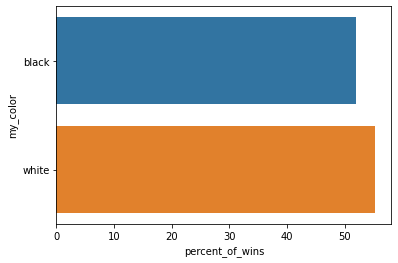

In [21]:
a = chess_df.groupby('my_color').agg({'my_result': 'mean'}).reset_index()
a = a.replace({0: 'black', 1: 'white'})
a.my_result = a.my_result * 100
a = a.rename(columns={'my_result': 'percent_of_wins'})
sns.barplot(x=a.percent_of_wins, y=a.my_color, orient='h')

Статистика говорит, что белым цветом я выигрываю почаще (55% партий), чем черными (52%)

#### Далее проанализируем и преобразуем колонку Events

<AxesSubplot:xlabel='Event', ylabel='index'>

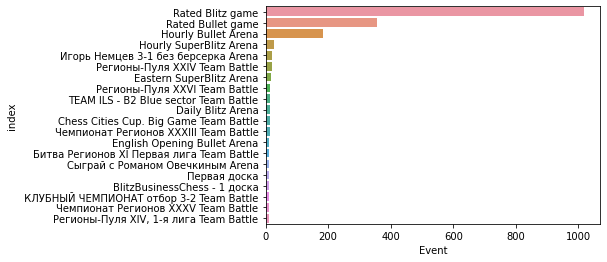

In [9]:
events = raw_data.Event.value_counts().to_frame().reset_index().head(20)
sns.barplot(data=events, x='Event', y='index')

Наиболее часто встречаемые события - не турнирные игры (Rated Blitz game, Rated Bullet game). Остальное - это игры, сыгранные в различных турнирах. На основании этого предлагаю сделать категориальную переменную Event, где 0 - это не турнирные игры, 1 - турнирные (все остальные). Разделять Blitz game и Bullet game не вижу смысла, так как это разделение будет в переменной, отвечающей за контроль времени.

In [13]:
chess_df['event'] = raw_data.Event.replace(['Rated Blitz game', 'Rated Bullet game', 'Casual Blitz game'], 0)
chess_df.loc[chess_df.event != 0, 'event'] = 1
chess_df['event'] = chess_df['event'].astype('int32')

In [14]:
print('Размерность основного датафрейма:', chess_df.shape)
chess_df.head()

Размерность основного датафрейма: (1952, 5)


,Date_Time,date_,my_result,my_color,event
0,2021-04-20 08:27:29,2021-04-20,0,0,0
1,2021-04-20 08:25:05,2021-04-20,1,1,0
2,2021-04-20 08:18:42,2021-04-20,0,0,0
3,2021-04-19 18:04:41,2021-04-19,1,1,1
4,2021-04-19 18:04:12,2021-04-19,1,0,1


#### Добавляю переменные my_rating (мой текущий рейтинг) и rating_diff (разница между моим рейтингом и рейтингом соперника)

In [15]:
chess_df['my_rating'] = raw_data['WhiteElo'].where(raw_data['White'] == 'shahmatpatblog', raw_data['BlackElo']).astype('int32')

In [16]:
chess_df['rating_diff'] = raw_data['WhiteElo'].astype('int32') - raw_data['BlackElo'].astype('int32')
chess_df['rating_diff'] = chess_df['rating_diff'].where(chess_df['my_color'] == 1, -chess_df['rating_diff'])

In [17]:
print('Размерность основного датафрейма:', chess_df.shape)
chess_df.head()

Размерность основного датафрейма: (1952, 7)


,Date_Time,date_,my_result,my_color,event,my_rating,rating_diff
0,2021-04-20 08:27:29,2021-04-20,0,0,0,2194,136
1,2021-04-20 08:25:05,2021-04-20,1,1,0,2190,101
2,2021-04-20 08:18:42,2021-04-20,0,0,0,2190,-1
3,2021-04-19 18:04:41,2021-04-19,1,1,1,2342,69
4,2021-04-19 18:04:12,2021-04-19,1,0,1,2342,747


Значение текущего рейтинга и разность моего рейтинга с соперником - весьма сильные признаки. Давайте взглянем на их скэттер плот в зависимости от результата партии 

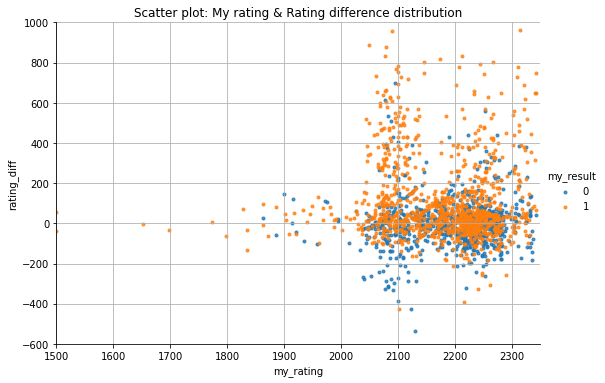

In [23]:
ax = sns.lmplot(x='my_rating', y='rating_diff', data=chess_df, hue='my_result', fit_reg=False, markers='.', aspect=1.5)
plt.title('Scatter plot: My rating & Rating difference distribution')
plt.grid()
plt.xlim([1500, 2350])
plt.ylim([-600, 1000]);

Как мы видим, чем больше мой рейтинг над рейтингом соперника (rating_diff > 0), тем чаще я побеждаю, и наоборот. Что, собственно говоря, предельно логично

#### На основе анализа колонки TimeControl создаю категориальную переменную time_control, указывающую тип контроля времени

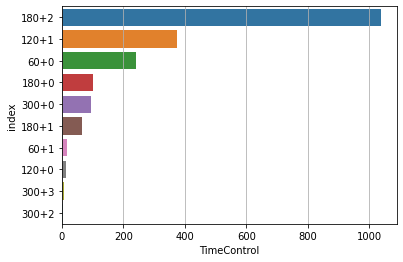

In [27]:
sns.barplot(data=raw_data.TimeControl.value_counts().to_frame().reset_index(), x='TimeControl', y='index')
plt.grid(axis='x')

Давайте разбираться в контролях времени. Больше половины партий я сыграл с контролем 180+2 (3 минуты с добавлением 2 с на ход). Немало партий в пулю - 120+1 (т.н "ленивая пуля") и 60+0 ("обычная пуля"). Предлагаю близкие по таймингу типы контроля времени объединить в две основные группы - пуля (0) и блиц (1). Таким образом для переменной time_contol, которую я создаю следующие категории: 0 - 60+0, 60+1, 120+0, 120+1, 1 - 180+0, 180+1, 180+2, 300+0, 300+2, 300+3

In [34]:
chess_df['time_control'] = raw_data.TimeControl.replace(['60+0', '60+1', '120+0', '120+1'], 0) \
                                    .replace(['180+0', '180+1', '180+2', '300+0', '300+2', '300+3'], 1)
chess_df['time_control'] = chess_df['time_control'].astype('int32')

In [35]:
print('Размерность основного датафрейма:', chess_df.shape)
chess_df.head()

Размерность основного датафрейма: (1952, 8)


,Date_Time,date_,my_result,my_color,event,my_rating,rating_diff,time_control
0,2021-04-20 08:27:29,2021-04-20,0,0,0,2194,136,0
1,2021-04-20 08:25:05,2021-04-20,1,1,0,2190,101,0
2,2021-04-20 08:18:42,2021-04-20,0,0,0,2190,-1,0
3,2021-04-19 18:04:41,2021-04-19,1,1,1,2342,69,1
4,2021-04-19 18:04:12,2021-04-19,1,0,1,2342,747,1


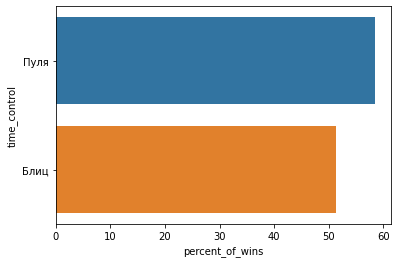

In [41]:
b = chess_df.groupby('time_control').agg({'my_result': 'mean'}).reset_index()
b = b.replace({0: 'Пуля', 1: 'Блиц'})
b.my_result = b.my_result * 100
b = b.rename(columns={'my_result': 'percent_of_wins'})
sns.barplot(x=b.percent_of_wins, y=b.time_control, orient='h');

Как оказалось, в пулю процент побед у меня больше. Это можно объяснить, что пока я еще не набрал свой максимальный рейтинг в пулю, т.к. играю в нее меньше, и сильных соперников там меньше, чем в блиц.

Кстати, глянем на изменение моего рейтинга по времени. Поскольку я играю в двух режимах - блиц и пуля, рейтинга будет два

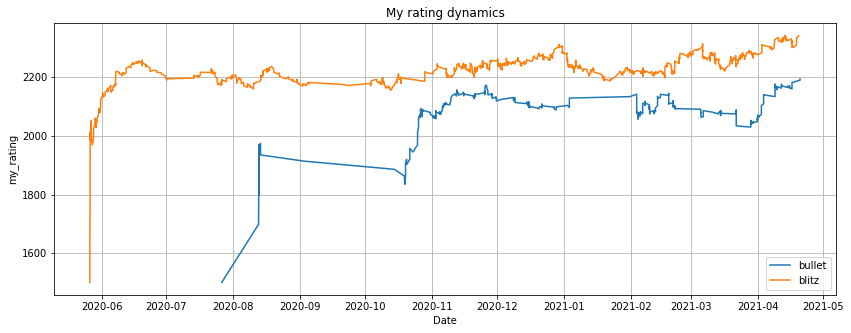

In [40]:
plt.figure(figsize=(14, 5))
ax = sns.lineplot(x=chess_df.Date_Time, y=chess_df.my_rating, hue=chess_df.time_control)
ax.xaxis.set_label_text('Date')
plt.legend(('bullet', 'blitz'), loc='lower right')
plt.grid()
plt.title('My rating dynamics');

#### Добавляю переменные - день недели и час суток игры (вдруг есть зависимость с моими результатами, например, в рабочие дни играю хуже, чем в выходные, вечером лучше, чем утром)

Создаю: day_of_week - категориальная переменная, от 1 до 7, обозначающая день недели игры (1 - Monday, ..., 7 - Sunday)

hour_of_game - час суток (время UTF, т.е. для получения моего времени надо прибавить +4 часа)

In [56]:
chess_df[['day_of_week']] = chess_df[['Date_Time']].applymap(lambda x: x.isoweekday())
chess_df[['hour_of_game']] = chess_df[['Date_Time']].applymap(lambda z: z.time().hour + 4)

In [57]:
print('Размерность основного датафрейма:', chess_df.shape)
chess_df.head()

Размерность основного датафрейма: (1952, 10)


,Date_Time,date_,my_result,my_color,event,my_rating,rating_diff,time_control,day_of_week,hour_of_game
0,2021-04-20 08:27:29,2021-04-20,0,0,0,2194,136,0,2,12
1,2021-04-20 08:25:05,2021-04-20,1,1,0,2190,101,0,2,12
2,2021-04-20 08:18:42,2021-04-20,0,0,0,2190,-1,0,2,12
3,2021-04-19 18:04:41,2021-04-19,1,1,1,2342,69,1,1,22
4,2021-04-19 18:04:12,2021-04-19,1,0,1,2342,747,1,1,22


Гистограмма распределения результатов по дням недели выгляди так:

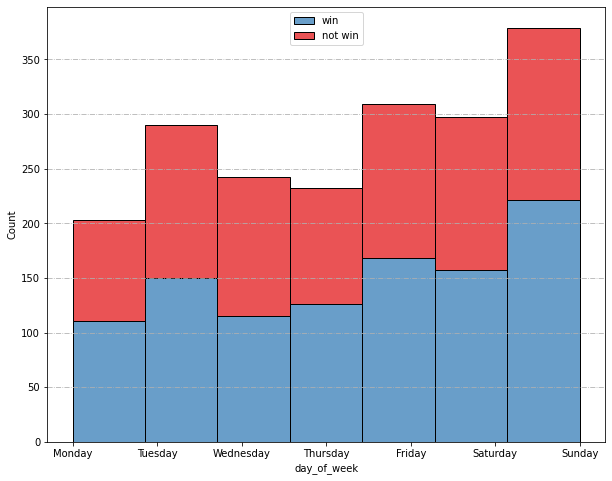

In [58]:
plt.figure(figsize=(10, 8))
sns.histplot(data=chess_df, x=chess_df.day_of_week, hue='my_result', bins=7, multiple='stack', palette='Set1')
plt.xticks(ticks=range(1, 8), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.legend(('win', 'not win'), loc='upper center')
plt.grid(axis='y', linestyle='-.')
plt.plot();

К выходным количество игр возрастает, и наибольшая доля побед именно в выходные. Логично, ведь я свеж и не отвлекаюсь на работу :)

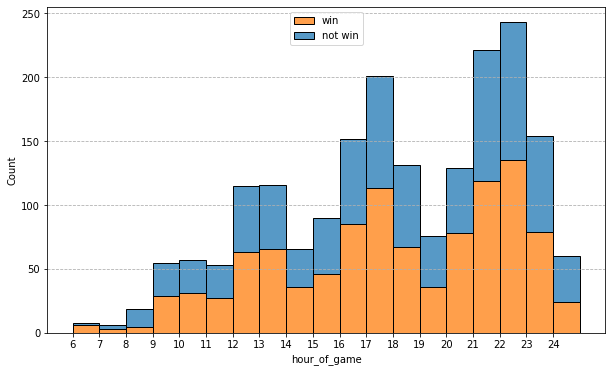

In [59]:
plt.figure(figsize=(10, 6))
sns.histplot(data=chess_df, x=chess_df.hour_of_game, hue='my_result', bins=19, multiple='stack')
plt.xticks(ticks=range(25))
plt.legend(('win', 'not win'), loc='upper center')
plt.grid(axis='y', linestyle='--')
plt.plot();

Из почасового распределения результатов можно сделать несколько интересных замечаний. Во-первых, есть несколько пиков - отрезков времени, когда я чаще всего играю. Это 12-13 часов (обеденный перерыв), 16-18 часов (окончание работы, еду домой), 20-23 (вечернее время дома). Во-вторых, есть "плохие" часы, когда результаты не очень (в начале дня, поздно вечером), и "хорошие часы", когда я чаще бываю в ударе. В-третьих, интересно посмотреть на это распределение только для рабочих дней и только для выходных.

In [ ]:
clf = LogisticRegression(random_state=28)

print('Logistic regression for all combinations of features')
list_scores, list_feat_names = [], []
for n_features in range(2, 16):
    iterator_ = combinations(range(15), n_features)
    for i in iterator_:
        #print (X_test.iloc[:, list(i)].columns)
        X_train = X_train_big.iloc[:, list(i)]
        X_test = X_test_big.iloc[:, list(i)]
        clf.fit(X_train, y_train)
        list_scores.append(clf.score(X_test, y_test))
        list_feat_names.append(list(X_test.columns))
        print('-'*50)
        print('Score = {:.3f} при {} фичах'.format(clf.score(X_test, y_test), len(X_test.columns)))
        print('Для обучения взяты фичи:\n{0}'.format(list(X_test.columns)))

In [ ]:
index_best = list_scores.index(max(list_scores))
print('Максимальный score = {:.3f} с набором фичей {}'.format(max(list_scores), list_feat_names[index_best]))

У одного единственного набора фичей наилучший score = 0.684!

In [ ]:
df_scores_logit = pd.DataFrame({'score': list_scores, 'features': list_feat_names})
df_scores_logit.sort_values(by='score', ascending=False).head(20)

### Лучший классификатор: logit (score = 0.684) с набором фичей ['my_color', 'elo_diff', 'event', 'time_control', 'day_of_week', 'last_7days_wins', 'count_today_games', 'win_rate_today_games', 'ECO_games', 'ECO_win_rate']